In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Function to simulate stable distributions using Chambers-Mallows-Stuck method
def simulate_stable(alpha, beta, gamma=1.0, delta=0.0, size=1000):
    """
    Generate random samples from a stable distribution using the Chambers-Mallows-Stuck method.

    Parameters:
    - alpha: stability parameter (0 < alpha <= 2)
    - beta: skewness parameter (-1 <= beta <= 1)
    - gamma: scale parameter (gamma > 0)
    - delta: location parameter
    - size: number of samples to generate

    Returns:
    - array of random samples from the specified stable distribution
    """
    # Validate parameters
    if not (0 < alpha <= 2):
        raise ValueError("Alpha must be in the range (0, 2]")
    if not (-1 <= beta <= 1):
        raise ValueError("Beta must be in the range [-1, 1]")
    if gamma <= 0:
        raise ValueError("Gamma must be positive")

    # Generate uniform and exponential random variables
    uniform = np.random.uniform(-np.pi/2, np.pi/2, size=size)
    exponential = np.random.exponential(1, size=size)

    # Special case for alpha = 1 and beta = 0 (Cauchy distribution)
    if alpha == 1 and beta == 0:
        return gamma * np.tan(uniform) + delta

    # Handle alpha = 1 case separately (different formula)
    if alpha == 1:
        # Formula for alpha = 1 with beta ≠ 0
        zeta = beta
        X = (2/np.pi) * ((np.pi/2 + beta * uniform) * np.tan(uniform) -
                         beta * np.log((np.pi/2 * exponential * np.cos(uniform)) /
                                      (np.pi/2 + beta * uniform)))
        return gamma * X + delta

    # Formula for alpha ≠ 1
    beta_tan_alpha = beta * np.tan(np.pi * alpha / 2)
    zeta = np.arctan(beta_tan_alpha) / alpha

    X = (np.sin(alpha * (uniform + zeta)) / (np.cos(uniform) ** (1/alpha)) *
        (np.cos(uniform - alpha * (uniform + zeta)) / exponential) ** ((1-alpha)/alpha))

    # Apply scale and location
    if alpha != 1:
        X = gamma * X + delta - gamma * beta_tan_alpha
    else:
        X = gamma * X + delta

    return X

# Function to create and save visualization
def plot_stable_distributions(alphas, betas, size=100000, filepath="stable_distributions.png"):
    """
    Generate and plot stable distributions for various alpha and beta values.
    Compare with normal distribution.

    Parameters:
    - alphas: list of alpha values to simulate
    - betas: list of beta values to simulate
    - size: number of samples to generate for each distribution
    - filepath: path to save the output image
    """
    # Set up a colorful style
    plt.style.use('seaborn-v0_8-whitegrid')
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap",
                                                   ['#1f77b4', '#ff7f0e', '#2ca02c',
                                                    '#d62728', '#9467bd', '#8c564b'])

    # Create figure with subplots
    n_rows = len(alphas)
    n_cols = len(betas)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharex=True)

    # Adjust the layout
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Generate normal distribution for comparison
    x_range = np.linspace(-20, 20, 1000)
    normal_pdf = stats.norm.pdf(x_range, 0, 1)

    # Loop through alpha and beta values
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            # Get current axis
            if n_rows > 1 and n_cols > 1:
                ax = axes[i, j]
            elif n_rows > 1:
                ax = axes[i]
            elif n_cols > 1:
                ax = axes[j]
            else:
                ax = axes

            # Generate stable distribution samples
            try:
                stable_samples = simulate_stable(alpha, beta, gamma=1, delta=0, size=size)

                # Remove extreme outliers for better visualization (keep 99.9% of data)
                lower_bound = np.percentile(stable_samples, 0.05)
                upper_bound = np.percentile(stable_samples, 99.95)
                filtered_samples = stable_samples[(stable_samples >= lower_bound) &
                                                 (stable_samples <= upper_bound)]

                # Plot histogram
                sns.histplot(filtered_samples, bins=100, stat='density', alpha=0.3,
                            color='#1f77b4', ax=ax, label='Histogram')

                # Plot KDE
                sns.kdeplot(filtered_samples, ax=ax, color='#ff7f0e',
                          lw=2, label='KDE (Stable)')

                # Plot normal PDF for comparison
                range_min, range_max = ax.get_xlim()
                x_norm = np.linspace(range_min, range_max, 1000)
                normal_pdf = stats.norm.pdf(x_norm, 0, 1)
                ax.plot(x_norm, normal_pdf, 'r--', lw=1.5, label='Normal PDF')

                # Set title and labels
                ax.set_title(f'Stable Distribution: α={alpha}, β={beta}')
                ax.set_xlabel('Value')
                ax.set_ylabel('Density')
                ax.legend()

                # Add text with distribution statistics
                mean = np.mean(filtered_samples)
                median = np.median(filtered_samples)
                std = np.std(filtered_samples)
                stats_text = f'Mean: {mean:.3f}\nMedian: {median:.3f}\nStd: {std:.3f}'
                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round',
                                                         alpha=0.1))

            except Exception as e:
                ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=ax.transAxes)

    # Add overall title
    fig.suptitle('Comparison of Stable Distributions with Normal Distribution',
                fontsize=16, y=0.98)

    # Save figure with transparent background
    plt.savefig(filepath, dpi=300, bbox_inches='tight', transparent=True)
    print(f"Figure saved to {filepath}")

    # Display the figure
    plt.tight_layout()
    return fig

# Function to create individual plots for specific parameter combinations
def plot_specific_stable_distributions(param_sets, size=100000, base_filepath="stable_dist"):
    """
    Generate and plot stable distributions for specific parameter combinations.

    Parameters:
    - param_sets: list of tuples (alpha, beta, gamma, delta, title)
    - size: number of samples to generate for each distribution
    - base_filepath: base path to save the output images
    """
    for i, params in enumerate(param_sets):
        alpha, beta, gamma, delta, title = params

        # Set up figure
        plt.figure(figsize=(10, 6))

        # Generate stable distribution samples
        stable_samples = simulate_stable(alpha, beta, gamma, delta, size=size)

        # Remove extreme outliers for better visualization
        lower_bound = np.percentile(stable_samples, 0.05)
        upper_bound = np.percentile(stable_samples, 99.95)
        filtered_samples = stable_samples[(stable_samples >= lower_bound) &
                                         (stable_samples <= upper_bound)]

        # Plot histogram
        sns.histplot(filtered_samples, bins=100, stat='density', alpha=0.3,
                    color='#1f77b4', label='Histogram')

        # Plot KDE
        sns.kdeplot(filtered_samples, color='#ff7f0e', lw=2, label='KDE (Stable)')

        # Plot normal PDF for comparison
        x_range = np.linspace(min(filtered_samples), max(filtered_samples), 1000)
        normal_pdf = stats.norm.pdf(x_range, np.mean(filtered_samples), np.std(filtered_samples))
        plt.plot(x_range, normal_pdf, 'r--', lw=1.5, label='Normal PDF')

        # Set title and labels
        plt.title(f'{title} (α={alpha}, β={beta}, γ={gamma}, δ={delta})')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()

        # Add text with distribution statistics
        mean = np.mean(filtered_samples)
        median = np.median(filtered_samples)
        std = np.std(filtered_samples)
        skew = stats.skew(filtered_samples)
        kurtosis = stats.kurtosis(filtered_samples)

        stats_text = (f'Mean: {mean:.3f}\nMedian: {median:.3f}\nStd: {std:.3f}\n'
                     f'Skewness: {skew:.3f}\nKurtosis: {kurtosis:.3f}')

        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

        # Save figure with transparent background
        filepath = f"{base_filepath}_{i+1}.png"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', transparent=True)
        print(f"Figure saved to {filepath}")

        plt.close()

Figure saved to stable_distributions_grid.png
Figure saved to stable_dist_1.png
Figure saved to stable_dist_2.png
Figure saved to stable_dist_3.png
Figure saved to stable_dist_4.png
Figure saved to stable_dist_5.png
Figure saved to stable_dist_gamma_1.png
Figure saved to stable_dist_gamma_2.png
Figure saved to stable_dist_gamma_3.png
Figure saved to stable_dist_beta_1.png
Figure saved to stable_dist_beta_2.png
Figure saved to stable_dist_beta_3.png
All simulations and visualizations completed.


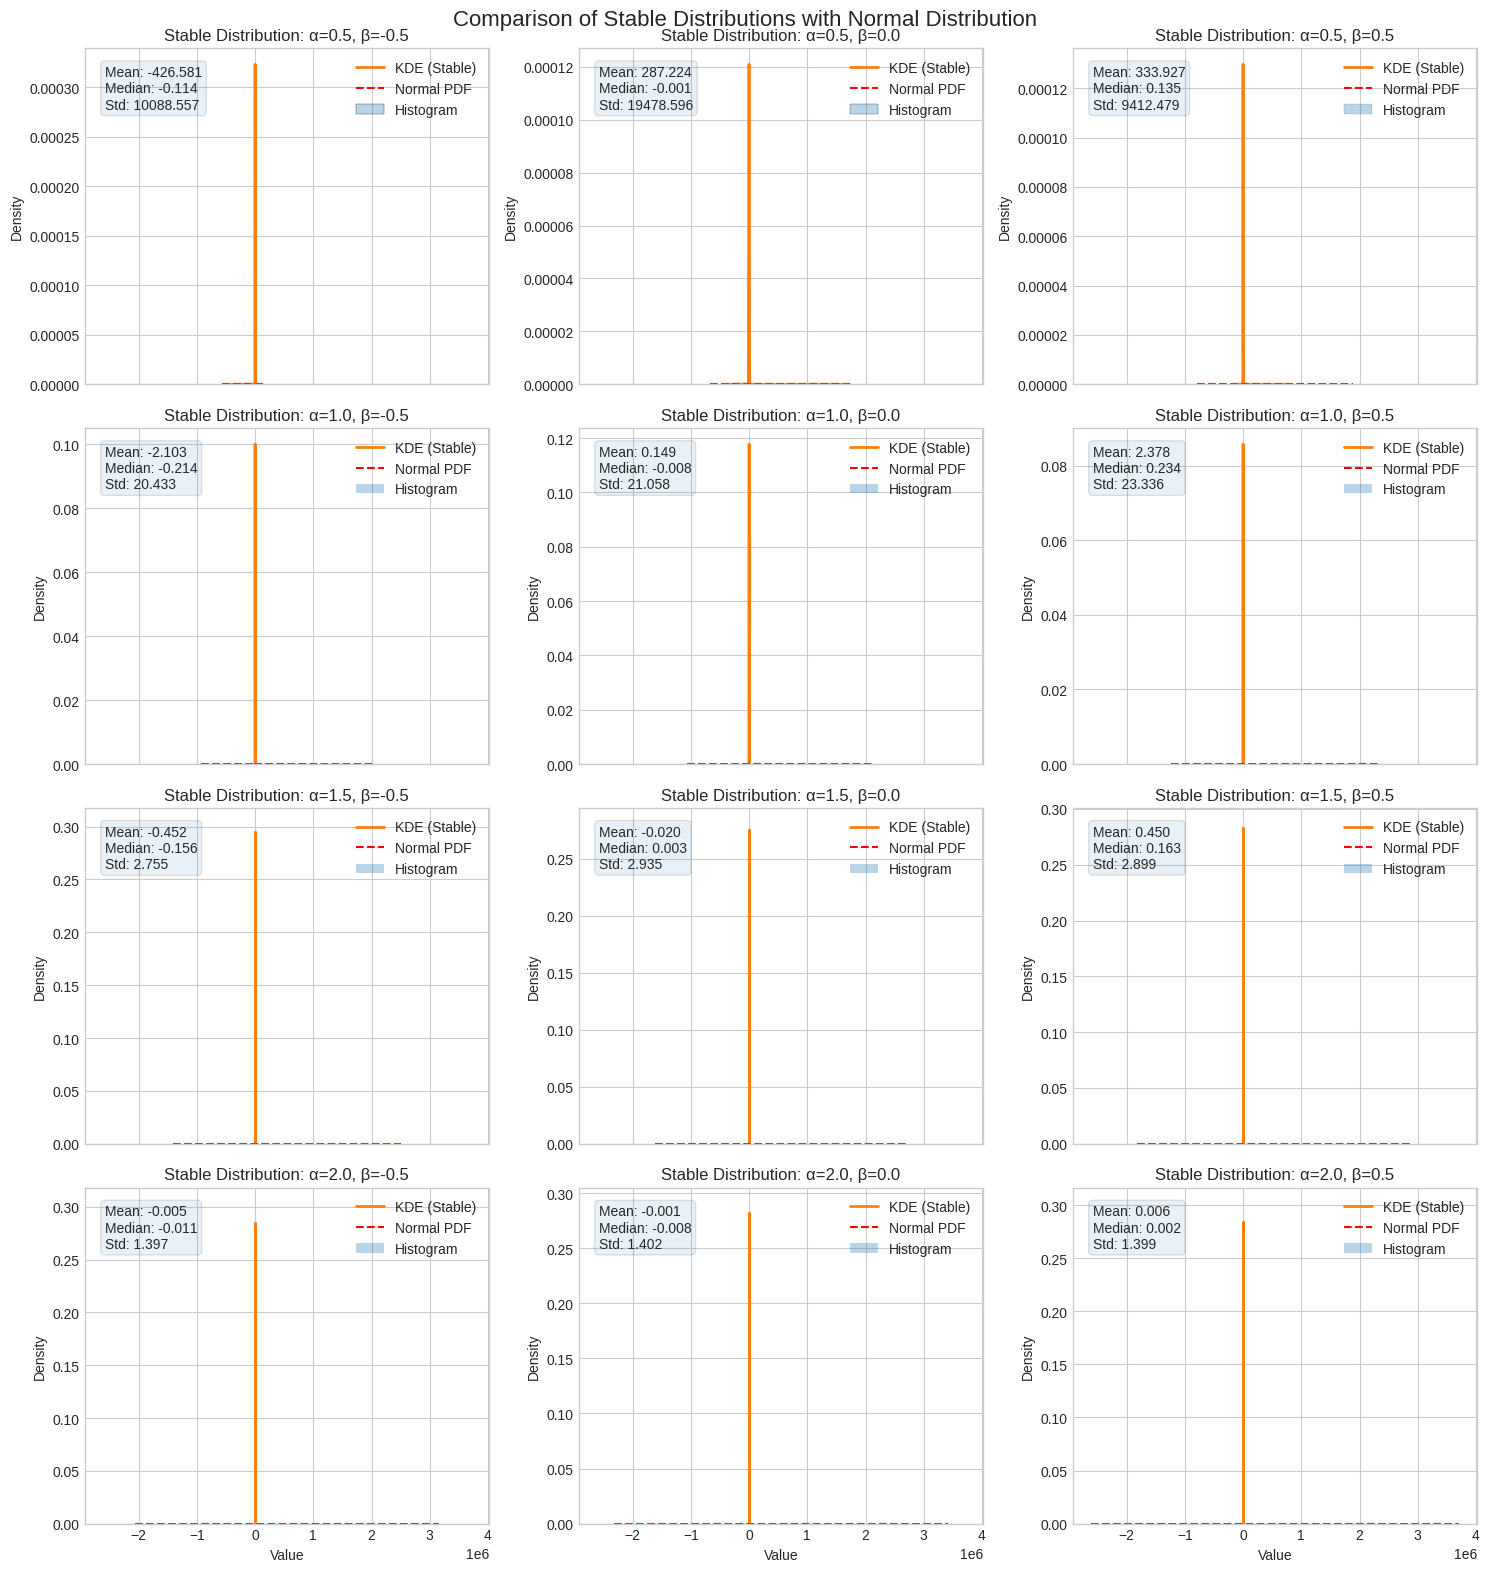

In [2]:
# Main execution
if __name__ == "__main__":
    # Example 1: Grid of stable distributions with different alpha and beta values
    alphas = [0.5, 1.0, 1.5, 2.0]
    betas = [-0.5, 0.0, 0.5]
    plot_stable_distributions(alphas, betas, size=50000, filepath="stable_distributions_grid.png")

    # Example 2: Specific distributions of interest
    param_sets = [
        (2.0, 0.0, 1.0, 0.0, "Normal Distribution"),  # Normal (Gaussian)
        (1.0, 0.0, 1.0, 0.0, "Cauchy Distribution"),  # Cauchy
        (0.5, 1.0, 1.0, 0.0, "Lévy Distribution"),    # Lévy
        (1.5, 0.0, 1.0, 0.0, "Holtsmark Distribution"),  # Holtsmark
        (1.7, 0.3, 1.0, 0.0, "Financial Returns-like Distribution"),  # Typical financial returns
    ]
    plot_specific_stable_distributions(param_sets, size=100000)

    # Example 3: Effect of scale parameter (gamma)
    gamma_param_sets = [
        (1.5, 0.0, 0.5, 0.0, "Stable Distribution (γ=0.5)"),
        (1.5, 0.0, 1.0, 0.0, "Stable Distribution (γ=1.0)"),
        (1.5, 0.0, 2.0, 0.0, "Stable Distribution (γ=2.0)"),
    ]
    plot_specific_stable_distributions(gamma_param_sets, size=100000,
                                      base_filepath="stable_dist_gamma")

    # Example 4: Effect of skewness parameter (beta)
    beta_param_sets = [
        (1.5, -0.8, 1.0, 0.0, "Left-Skewed Stable Distribution"),
        (1.5, 0.0, 1.0, 0.0, "Symmetric Stable Distribution"),
        (1.5, 0.8, 1.0, 0.0, "Right-Skewed Stable Distribution"),
    ]
    plot_specific_stable_distributions(beta_param_sets, size=100000,
                                      base_filepath="stable_dist_beta")

    print("All simulations and visualizations completed.")

Mean: -0.007
Median: -0.006
Std: 1.405
Skewness: -0.007
Kurtosis: -0.102
Figure saved to Normal Distribution.png


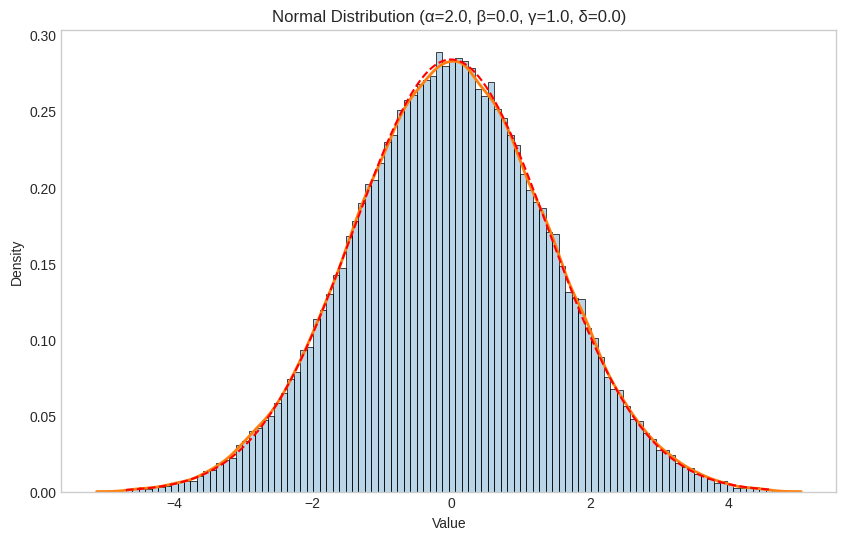

Mean: -0.084
Median: -0.005
Std: 18.985
Skewness: -1.763
Kurtosis: 286.636
Figure saved to Cauchy Distribution.png


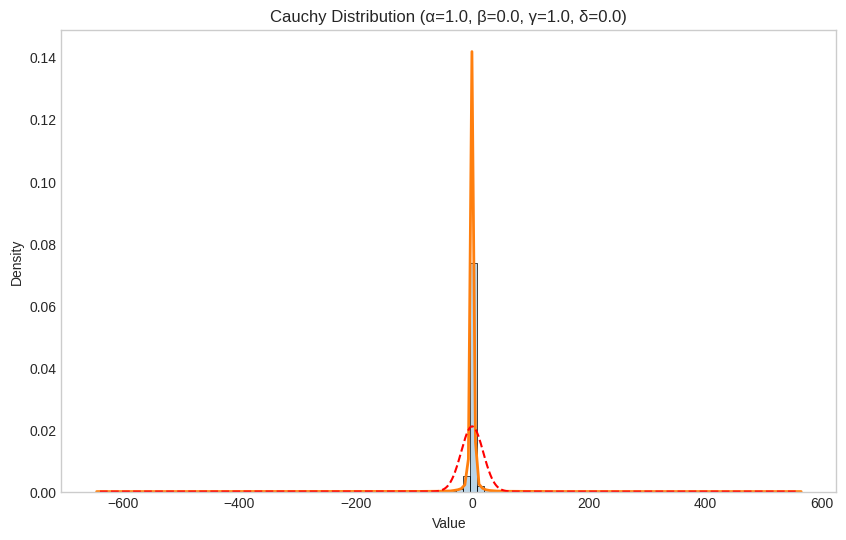

Mean: 854.567
Median: 0.102
Std: 23891.691
Skewness: 48.502
Kurtosis: 2772.936
Figure saved to Lévy Distribution.png


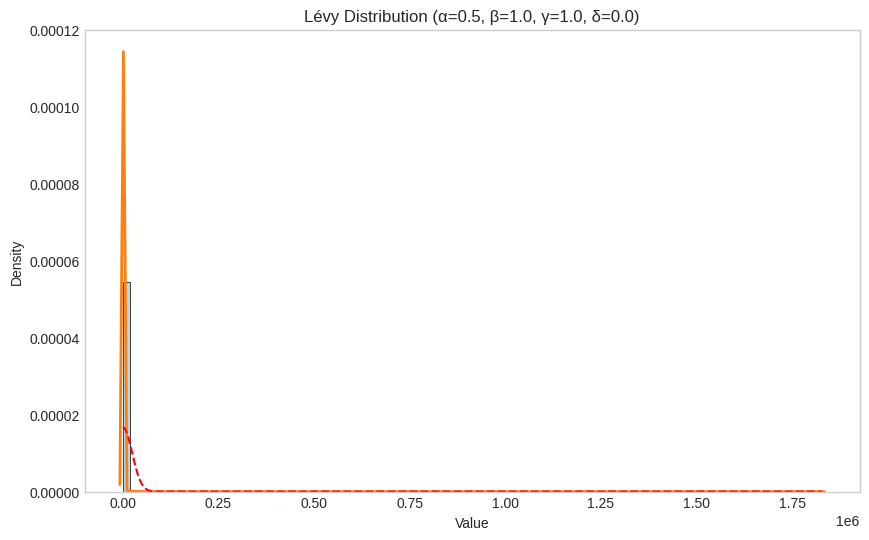

Mean: -0.001
Median: 0.001
Std: 2.969
Skewness: -0.576
Kurtosis: 58.059
Figure saved to Holtsmark Distribution.png


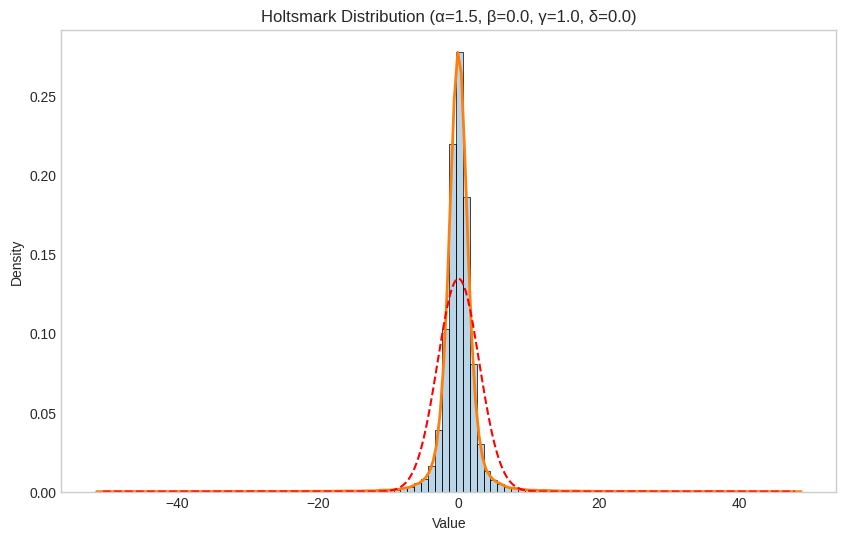

Mean: 0.141
Median: 0.045
Std: 2.015
Skewness: 2.130
Kurtosis: 32.661
Figure saved to Financial Returns-like Distribution.png


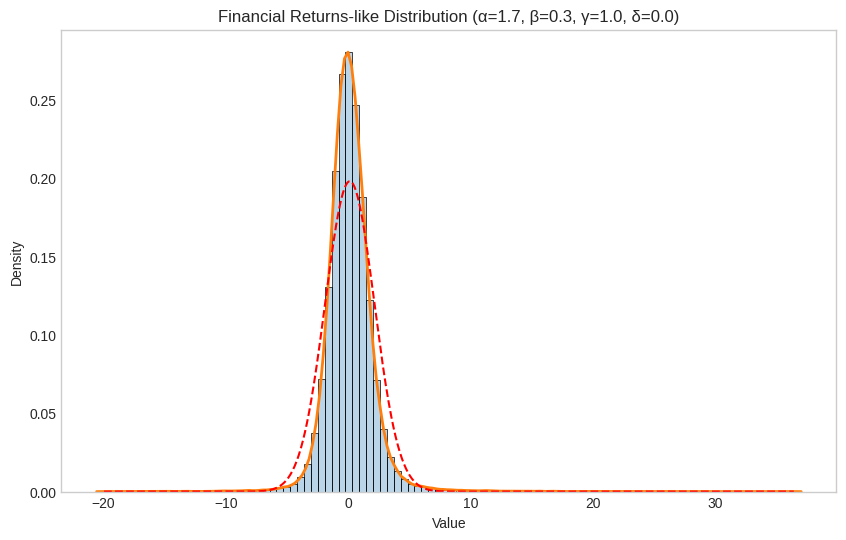

In [13]:
### Example 2: Specific distributions of interest
param_sets = [
    (2.0, 0.0, 1.0, 0.0, "Normal Distribution"),  # Normal (Gaussian)
    (1.0, 0.0, 1.0, 0.0, "Cauchy Distribution"),  # Cauchy
    (0.5, 1.0, 1.0, 0.0, "Lévy Distribution"),    # Lévy
    (1.5, 0.0, 1.0, 0.0, "Holtsmark Distribution"),  # Holtsmark
    (1.7, 0.3, 1.0, 0.0, "Financial Returns-like Distribution"),  # Typical financial returns
]
size=100000

for i, params in enumerate(param_sets):
    alpha, beta, gamma, delta, title = params

    # Set up figure
    plt.figure(figsize=(10, 6))

    # Generate stable distribution samples
    stable_samples = simulate_stable(alpha, beta, gamma, delta, size=size)

    # Remove extreme outliers for better visualization
    lower_bound = np.percentile(stable_samples, 0.05)
    upper_bound = np.percentile(stable_samples, 99.95)
    filtered_samples = stable_samples[(stable_samples >= lower_bound) &
                                     (stable_samples <= upper_bound)]

    # Plot histogram
    sns.histplot(filtered_samples, bins=100, stat='density', alpha=0.3,
                color='#1f77b4', label='Histogram')

    # Plot KDE
    sns.kdeplot(filtered_samples, color='#ff7f0e', lw=2, label='KDE (Stable)')

    # Plot normal PDF for comparison
    x_range = np.linspace(min(filtered_samples), max(filtered_samples), 1000)
    normal_pdf = stats.norm.pdf(x_range, np.mean(filtered_samples), np.std(filtered_samples))
    plt.plot(x_range, normal_pdf, 'r--', lw=1.5, label='Normal PDF')

    # Set title and labels
    plt.title(f'{title} (α={alpha}, β={beta}, γ={gamma}, δ={delta})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    # plt.legend()
    plt.grid(False)

    # Add text with distribution statistics
    mean = np.mean(filtered_samples)
    median = np.median(filtered_samples)
    std = np.std(filtered_samples)
    skew = stats.skew(filtered_samples)
    kurtosis = stats.kurtosis(filtered_samples)

    stats_text = (f'Mean: {mean:.3f}\nMedian: {median:.3f}\nStd: {std:.3f}\n'
                 f'Skewness: {skew:.3f}\nKurtosis: {kurtosis:.3f}')

    print(stats_text)

    # plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
    #        verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

    # Save figure with transparent background
    filepath = f"{title}.png"
    plt.savefig(filepath, dpi=300, bbox_inches='tight', transparent=True)
    print(f"Figure saved to {filepath}")
    plt.show()

    plt.close()